In [704]:
# Script written with Python 3.7.4
%matplotlib inline

import matplotlib.pyplot as plt # v. 3.1.1
import numpy as np # v. 1.16.2
import pandas as pd # v. 0.24.2
import seaborn as sns # v. 0.9.0
import scipy.stats as ss # v. 1.3.2

# Summary

This script will build a predictive model to estimate dissolved inorganic nitrogen (DIN) concentrations based on summer (June-September) data collected from YSI 6600 V2 profiles, Norfolk International Airport (ORF) METAR network, and a NOAA bouy at Sewell's Point in Norfolk, VA.

The script is broken into seven sections:

1) The full training/test/validation dataset is imported and corrected for outliers and known erroneous values. YSI data was collected by the Mulholland lab at Old Dominion University, measured at the Norfolk Yacht and Country Club (NYCC). All YSI is corrected based on lab standards and extracted measurements (chlorophyll). Wind speed and precipitation data was collected from the NOAA weather database (https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:13737/detail). DIN values are reported as a total of NO2 and NO3 in uM, with a detection limit of 0.14 uM.

2) 20% of the full dataset is randomly selected and witheld for later validation of the model, leaving 80% for training and testing the model.

3) Data points with extreme DIN values are replicated to helping create a more balanced model (Sammartino et al., 2018 and Thessen, 2016). 

4) Predictor variables are chosen and data is split into training/testing and validation sets.

5) Predictor variables are scaled based on the training/testing data.

6) Hyperparameter sensitivity analysis is performed and the the model is tuned.

7) Performance of the model is assesed using the 20% withheld validation dataset.

* Special credit to Corday Selden for providing the code for cross validation. Original code found here: https://github.com/cselden/OEAS895_FinalProject/blob/master/OEAS895_ProjectPart3_B_RandomForestModel_ProfilePred_NFR.ipynb

# 1. Fully combined dataset is imported and corrected for outliers and known erroneous values

In [705]:
# Reading in the .csv file with all data.
infile = 'Combined_List_R_UPDATED_HEADERS.csv'

#Creating the data variable.
data = pd.read_csv(infile, sep = (','))

# Let's take a quick look at the data.
data

,Date,Month,Day,Year,Depth_ID,Depth,Time,NH4,Urea,DIN,...,pH,Chl,Turb,DO,Tide,Precipitation,Wind_Speed,Wind_Dir,Bloom,Unnamed: 22
0,6/6/2016,6,6,2016,1,0.50,14:00,0.46,0.08000,0.557,...,NaN,15.20000,9.3,7.47,0.509,0.003333,9.291667,233.043478,1,NaN
1,6/6/2016,6,6,2016,3,5.00,14:00,2.05,0.08000,0.346,...,NaN,10.90000,4.7,6.62,0.509,0.003333,9.291667,233.043478,1,NaN
2,6/7/2016,6,7,2016,1,0.50,14:00,0.36,0.08000,0.275,...,7.54,27.30000,8.6,9.32,0.359,0.022500,6.741935,178.928571,1,NaN
3,6/7/2016,6,7,2016,3,5.50,14:00,2.45,0.10441,1.506,...,7.11,11.80000,18.8,6.93,0.359,0.022500,6.741935,178.928571,1,NaN
4,6/8/2016,6,8,2016,1,0.50,14:00,0.08,0.08000,0.214,...,7.82,14.40000,12.4,7.75,0.280,0.000000,11.000000,303.333333,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,10/1/2019,10,1,2019,2,3.00,14:00,NaN,0.08000,4.870,...,NaN,6.87246,4.5,6.14,0.727,0.000000,3.520000,85.000000,0,NaN
926,10/1/2019,10,1,2019,3,5.75,14:00,NaN,0.08000,4.870,...,NaN,5.88841,6.9,5.88,0.727,0.000000,3.520000,85.000000,0,NaN
927,10/1/2019,10,1,2019,1,0.25,14:00,NaN,0.11000,1.660,...,NaN,27.93113,9.5,7.31,0.727,0.000000,3.520000,85.000000,0,NaN
928,10/1/2019,10,1,2019,2,0.75,14:00,NaN,0.16000,1.700,...,NaN,25.76622,9.5,7.19,0.727,0.000000,3.520000,85.000000,0,NaN


In [706]:
# Making corrections to data that appear to have outliers (negative values, extreme high values, etc.)
corr_data = data[data.DIN < 40]
corr_data = corr_data[corr_data.DIN > 0.14] #This is the detection limit of NOx
corr_data = corr_data[corr_data.Chl < 200] # Maximum accurate chlorophyll measurement by YSI 6600 V2 sondes
corr_data = corr_data[corr_data.Turb > 0] #Getting rid of erroneous negative turbidity values
corr_data = corr_data[corr_data.Turb < 50] #Correcting for known turbidity spikes when YSI sondes hit sediment during profiles.
corr_data = corr_data[corr_data.Sal > 15] #Corrected for known low salinity values due to probe failure. Will also correct for error temperature values
corr_data = corr_data[corr_data.pH >6.7] #Correcting for know pH probe failures.

corr_data.Precipitation = corr_data.Precipitation * 8 * 0.0254 #Transforming precipitation from 1/8" to inches to meters
corr_data.Wind_Speed = corr_data.Wind_Speed * 0.44704 #Transforming wind speed from miles/hour to meters/second

# 2. The data is formatted to include only D1 & D3 samples from June (6) through September (9) and is then randomized
* The data from depths 1 and 3 are chosen because they are the most impacted by the variables being used in the model, particularly precipitation and wind speed. D2 is too arbitrary to consider between stations of vastly different total depths.
* Data from "summer" months, June-September are chosen because all four years used for the model have consistent data in those months.
* Randomization is done to ensure random selection of data in the model.

In [707]:
used_data = corr_data[(corr_data.Depth_ID == 1) | (corr_data.Depth_ID == 3)] #Using only depths 1 and 3 data.
used_data = used_data[(used_data.Month == 6) | (used_data.Month == 7) | (used_data.Month == 8) | (used_data.Month == 9)] #Limiting to summer months slightly improves rmse
used_data

,Date,Month,Day,Year,Depth_ID,Depth,Time,NH4,Urea,DIN,...,pH,Chl,Turb,DO,Tide,Precipitation,Wind_Speed,Wind_Dir,Bloom,Unnamed: 22
2,6/7/2016,6,7,2016,1,0.50,14:00,0.36,0.08000,0.275,...,7.54,27.30000,8.6,9.32,0.359,0.004572,3.013915,178.928571,1,NaN
3,6/7/2016,6,7,2016,3,5.50,14:00,2.45,0.10441,1.506,...,7.11,11.80000,18.8,6.93,0.359,0.004572,3.013915,178.928571,1,NaN
4,6/8/2016,6,8,2016,1,0.50,14:00,0.08,0.08000,0.214,...,7.82,14.40000,12.4,7.75,0.280,0.000000,4.917440,303.333333,1,NaN
6,6/8/2016,6,8,2016,3,5.50,14:00,0.99,0.08000,0.943,...,7.75,22.50000,7.5,7.28,0.280,0.000000,4.917440,303.333333,1,NaN
9,6/9/2016,6,9,2016,3,5.75,14:00,0.35,0.08000,0.193,...,7.83,14.50000,16.9,7.37,-0.058,0.000000,3.967480,275.652174,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,9/20/2019,9,20,2019,1,0.50,14:00,NaN,0.13000,0.200,...,7.21,31.28388,14.6,9.10,0.311,0.000000,1.825413,106.086956,0,NaN
911,9/20/2019,9,20,2019,3,2.00,14:00,NaN,0.08000,0.230,...,6.80,29.22441,21.6,7.71,0.311,0.000000,1.825413,106.086956,0,NaN
912,9/24/2019,9,24,2019,1,1.00,14:00,NaN,0.08000,15.330,...,7.45,17.09642,5.6,7.11,-0.035,0.000000,3.315547,113.750000,0,NaN
914,9/24/2019,9,24,2019,3,5.00,14:00,NaN,0.09000,4.050,...,7.28,10.91801,12.1,6.74,-0.035,0.000000,3.315547,113.750000,0,NaN


In [708]:
used_data.sample(frac=1) # Randomizing the rows so that cross-correlation is more randomly sampled

,Date,Month,Day,Year,Depth_ID,Depth,Time,NH4,Urea,DIN,...,pH,Chl,Turb,DO,Tide,Precipitation,Wind_Speed,Wind_Dir,Bloom,Unnamed: 22
600,9/9/2018,9,9,2018,1,0.50,14:00,NaN,0.10,3.200,...,7.75,18.90000,17.4,5.16,1.061,0.018288,3.423049,141.515152,1,NaN
623,9/28/2018,9,28,2018,3,5.75,14:00,NaN,0.08,10.480,...,7.46,12.90000,19.9,5.68,0.627,0.000325,3.681506,171.818182,1,NaN
587,9/4/2018,9,4,2018,3,5.25,14:00,NaN,0.08,1.880,...,7.78,17.40000,13.4,5.70,-0.196,0.000000,1.583267,58.260870,1,NaN
737,7/11/2019,7,11,2019,1,0.25,14:00,NaN,NaN,0.250,...,8.28,42.95421,16.6,8.91,-0.140,0.013208,4.364522,236.285714,0,NaN
259,7/10/2017,7,10,2017,1,0.75,14:00,0.06,0.38,0.330,...,7.86,23.60000,10.9,7.92,0.424,0.000000,2.682240,120.454546,0,42926|0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,8/30/2018,8,30,2018,3,5.50,14:00,NaN,0.17,0.450,...,7.61,14.80000,17.4,5.70,0.207,0.008362,3.563172,167.096774,1,NaN
772,7/24/2019,7,24,2019,1,0.25,14:00,NaN,0.13,1.510,...,7.97,15.03695,7.0,6.95,0.081,0.000000,4.310743,192.142857,0,NaN
12,6/10/2016,6,10,2016,3,5.75,14:00,0.85,0.08,0.176,...,7.89,16.60000,21.1,7.62,-0.127,0.000000,3.837093,189.565217,1,NaN
39,6/19/2016,6,19,2016,3,4.75,14:00,7.45,0.08,3.811,...,7.35,10.50000,23.3,5.49,0.382,0.000000,1.591462,162.727273,1,NaN


# 3. Data with extreme DIN values are replicated
* Data points including extreme DIN values are very few in this dataset, therefore replication of those values can be useful in helping create a more balanced model (Sammartino et al., 2018 and Thessen, 2016).  

In [709]:
#Replicating data that has DIN values above 8 uM, based on the 95% confidence interval

#Test the multiplication value between 3 and 6
df_repeated = pd.concat([used_data[used_data.DIN > 8]]*2, ignore_index=True)
df_repeated

,Date,Month,Day,Year,Depth_ID,Depth,Time,NH4,Urea,DIN,...,pH,Chl,Turb,DO,Tide,Precipitation,Wind_Speed,Wind_Dir,Bloom,Unnamed: 22
0,6/18/2016,6,18,2016,3,5.00,14:00,9.8,0.08000,13.986,...,7.47,10.60000,17.9,5.89,0.506,0.000000,4.880187,59.583333,1,NaN
1,7/1/2016,7,1,2016,3,4.75,14:00,2.07,0.08000,14.270,...,7.83,18.00000,17.0,7.11,0.044,0.001355,3.413760,177.419355,1,NaN
2,8/4/2016,8,4,2016,3,5.25,14:00,6.749311295,0.39566,11.741,...,7.35,12.40000,21.4,5.42,0.663,0.000000,4.401625,69.200000,1,NaN
3,8/8/2016,8,8,2016,3,5.50,14:00,7.724517906,0.08000,14.206,...,7.63,12.80000,16.3,5.95,0.020,0.000113,2.123440,71.250000,1,NaN
4,8/9/2016,8,9,2016,3,5.50,14:00,4.230054645,0.18337,33.213,...,7.47,11.80000,22.3,6.01,-0.017,0.031433,3.553395,101.081081,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,9/28/2018,9,28,2018,3,5.75,14:00,NaN,0.08000,10.480,...,7.46,12.90000,19.9,5.68,0.627,0.000325,3.681506,171.818182,1,NaN
84,9/30/2018,9,30,2018,1,1.50,14:00,NaN,0.08000,10.340,...,7.90,25.70000,8.8,7.73,0.303,0.000000,2.110029,89.583333,1,NaN
85,9/30/2018,9,30,2018,3,5.50,14:00,NaN,0.08000,11.780,...,7.61,14.80000,17.4,5.70,0.303,0.000000,2.110029,89.583333,1,NaN
86,9/20/2019,9,20,2019,3,5.75,14:00,NaN,0.08000,8.830,...,7.39,42.72538,6.7,5.97,0.311,0.000000,1.825413,106.086956,0,NaN


In [710]:
#Adding the replicated data to the used data
used_data = used_data.append(df_repeated) 
used_data

,Date,Month,Day,Year,Depth_ID,Depth,Time,NH4,Urea,DIN,...,pH,Chl,Turb,DO,Tide,Precipitation,Wind_Speed,Wind_Dir,Bloom,Unnamed: 22
2,6/7/2016,6,7,2016,1,0.50,14:00,0.36,0.08000,0.275,...,7.54,27.30000,8.6,9.32,0.359,0.004572,3.013915,178.928571,1,NaN
3,6/7/2016,6,7,2016,3,5.50,14:00,2.45,0.10441,1.506,...,7.11,11.80000,18.8,6.93,0.359,0.004572,3.013915,178.928571,1,NaN
4,6/8/2016,6,8,2016,1,0.50,14:00,0.08,0.08000,0.214,...,7.82,14.40000,12.4,7.75,0.280,0.000000,4.917440,303.333333,1,NaN
6,6/8/2016,6,8,2016,3,5.50,14:00,0.99,0.08000,0.943,...,7.75,22.50000,7.5,7.28,0.280,0.000000,4.917440,303.333333,1,NaN
9,6/9/2016,6,9,2016,3,5.75,14:00,0.35,0.08000,0.193,...,7.83,14.50000,16.9,7.37,-0.058,0.000000,3.967480,275.652174,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,9/28/2018,9,28,2018,3,5.75,14:00,NaN,0.08000,10.480,...,7.46,12.90000,19.9,5.68,0.627,0.000325,3.681506,171.818182,1,NaN
84,9/30/2018,9,30,2018,1,1.50,14:00,NaN,0.08000,10.340,...,7.90,25.70000,8.8,7.73,0.303,0.000000,2.110029,89.583333,1,NaN
85,9/30/2018,9,30,2018,3,5.50,14:00,NaN,0.08000,11.780,...,7.61,14.80000,17.4,5.70,0.303,0.000000,2.110029,89.583333,1,NaN
86,9/20/2019,9,20,2019,3,5.75,14:00,NaN,0.08000,8.830,...,7.39,42.72538,6.7,5.97,0.311,0.000000,1.825413,106.086956,0,NaN


# 4. Predictor variables are chosen and data is split into training/testing and validation sets
* The Variables chosen are known to have the largest effect on nutrient concentrations as well as expressing a distinct seasonality.
    * Chlorophyll a is measured in ug/L and is a proxy for phytoplankton biomass.
    * Dissolved oxygen is measured in mg/L and is a good proxy for the biological state of the water (heterotrophic or autotrophic).
    * Temperature is measured in degrees Celsius and is a proxy for seasonal/climatological variations.
    * Salinity is a unitless measurement and is a proxy for tidal cycle and freshwater input from rain and runoff.
    * Wind speed is measured in meters per second and is a good proxy for water mass mixing likely occurring.
    * Precipitation is measured in meters and is the total cumulative rainfall per day. It is a good proxy for climatological events and amount of freshwater input into the surface waters.
* 20% of the full dataset, including the added replications, is randomly selected and withheld from the model for later validation of model results.

In [711]:
# Select the predictive variables for the model
y = used_data.DIN #value to be predicted with the model
X = used_data[['Chl','DO','Temp','Sal','Wind_Speed','Precipitation']]
print(np.shape(y))
print(np.shape(X))

(442,)
(442, 6)


In [712]:
from sklearn.model_selection import train_test_split # v. 0.22.1

X_TT,X_VAL,y_TT,y_VAL = train_test_split(X,y,test_size=0.2)

# # reformat y_val to match y_pred later (THANKS CORDAY!)
y_VAL = np.array(y_VAL, dtype = float).reshape(len(y_VAL),)

print(X_TT.shape)
print(y_TT.shape)
print(X_VAL.shape)
print(y_VAL.shape)

(353, 6)
(353,)
(89, 6)
(89,)


# 5. Predictor variables are scaled based on the training/testing data

In [713]:
from sklearn.preprocessing import StandardScaler # v. 0.22.1

# scale all x data based on training data
scaler = StandardScaler()
scaler.fit(X_TT)

X_TT = scaler.transform(X_TT)
X_VAL = scaler.transform(X_VAL)

# 6. Hyperparameter sensitivity analysis is performed and the model is tuned

In [714]:
from sklearn.model_selection import KFold # v. 0.22.1
from sklearn.model_selection import GridSearchCV # v. 0.22.1
from sklearn.ensemble import RandomForestRegressor # v. 0.22.1
from sklearn import metrics # v. 0.22.1

# create model object
model = RandomForestRegressor()

# define type of cross validation to be used
cv = KFold(n_splits = 9, shuffle = True)

# set-up hyperparameter grid
treecount = np.arange(1,51,2) # number of decisions trees in the ensemble
maxdepth = np.arange(1,21,2) # longest path between root node and final node

param_grid = {'n_estimators':treecount, 'max_depth':maxdepth}

# define scoring parameters to evaluate the predictions on the test set
scoring = 'r2'

# create GridSearchCV object
grid_cv = GridSearchCV(model, param_grid, scoring = scoring, cv = cv, refit = True) # when refit = True, will refit the best
# estimator with the entire dataset

# fit model to the train/test data
grid_cv.fit(X_TT,np.ravel(y_TT, order = 'C'))

mean_test_score = grid_cv.cv_results_['mean_test_score']
std_test_score = grid_cv.cv_results_['std_test_score']
best_std_test_score = grid_cv.cv_results_['std_test_score'][mean_test_score ==  grid_cv.best_score_]

print("Tuned Parameter(s): {}".format(grid_cv.best_params_))
print("Best score is: %f +/- %f" % (grid_cv.best_score_,best_std_test_score)) # mean cross-validated score of the best estimator

Tuned Parameter(s): {'max_depth': 19, 'n_estimators': 21}
Best score is: 0.602965 +/- 0.278214


F:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 7. Performance of the model is assesed using the 20% withheld validation dataset

VALIDATION DATASET (black line), r2:  0.742776, rmse:  3.831029, p value:  0.000000


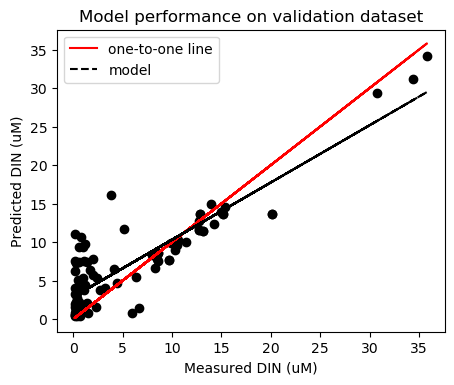

In [715]:
# predict y for validation data subset
y_pred = grid_cv.predict(X_VAL)

# plot predicted validation y against true validation y
fig, (ax) =  plt.subplots(1, 1, figsize = (5, 4), dpi = 100)

plt.plot(y_VAL,y_pred,'ko')
plt.plot(y_VAL,y_VAL, color = 'r', label = "one-to-one line")

plt.xlabel('Measured DIN (uM)')
plt.ylabel('Predicted DIN (uM)')

# perform and plot linear regression of true y against predicted y
slope, intercept, r_value, p_value, std_err = ss.linregress(y_VAL,y_pred)
line = slope*y_VAL + intercept
plt.plot(y_VAL,line, "k--", label = "model")

# calculate r2 and rmse using sklearn calculation method (differs slightly from ss method)
r2_comp = metrics.r2_score(y_VAL,y_pred)
rmse_comp = np.sqrt(metrics.mean_squared_error(y_VAL,y_pred))

ax.legend()
plt.title("Model performance on validation dataset")

print("VALIDATION DATASET (black line), r2:  %f, rmse:  %f, p value:  %f" % (r2_comp,rmse_comp,p_value))